In [25]:
import pandas as pd
import numpy as np
import glob as glob
import os
import re
from rdkit.Chem import rdchem
from multiprocessing import Pool

import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# G = nx.read_graphml('eom-net_0p1_new-rem-blink_k3.graphml')
# G = nx.read_graphml('eom-net_0p01_lbl.graphml')

import build_tools as wt

from rdkit.Chem import rdFMCS
from rdkit.Chem import MolFromSmiles, MolFromSmarts, MolToInchiKey
from rdkit.Chem.Draw import MolsToGridImage

import shutil
import json
from collections import Counter
import numpy as np
import pandas as pd
from rdkit import Chem
import os

sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink
# sys.path.insert(0,'/global/homes/b/bpb/repos/scndb/')


sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

In [26]:

smiles_col = 'smiles_identity'

# Maximum allowed distance between identity hits for clustering
max_node_distance = 2

In [27]:
df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/top_scoring_inchikey.pkl')
all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/all_spectra_backup.pkl')

# df = pd.read_pickle('top_scoring_inchikey_lbl.pkl')
# all_df = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/spectral_libraries/temp_backup_lbl.pkl')

all_df['nl_spectrum'] = all_df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)

all_df['sum_frag_intensity'] = all_df['mdm_i_vals'].apply(lambda x: np.sum(x))
all_df['original_spectrum'] = all_df['nl_spectrum']#df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)
all_df = all_df[all_df['sum_frag_intensity']>0]
all_df = all_df[pd.notna(all_df['predicted_formula'])]
all_df = all_df[all_df['massive_id'].isin(df['massive_id'])]
df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x))
all_df

,original_index,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,...,mdm_i_vals,original_mz_vals,original_i_vals,predicted_formula,estimated_fdr,ms2_mz_vals,ms2_i_vals,nl_spectrum,sum_frag_intensity,original_spectrum
0,0,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,"[10721465.0, 656960.5625, 56297.25]","[136.58860778808594, 111.14517211914062, 111.7...","[14613.318359375, 140141.578125, 18139.5761718...",C8H14O4,0.000000,NaN,NaN,"[[111.08161926269531, 129.09226989746094, 155....",1.143472e+07,"[[111.08161926269531, 129.09226989746094, 155...."
1,1,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,"[9762908.0, 227528.5, 317414.90625]","[143.10801696777344, 126.10077667236328, 125.1...","[227528.5, 30968.73046875, 66824.34375, 10057....",C9H16O4,0.000000,NaN,NaN,"[[125.0973129272461, 143.10801696777344, 169.0...",1.030785e+07,"[[125.0973129272461, 143.10801696777344, 169.0..."
2,2,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,"[7082600.0, 28277.291015625, 60962.609375, 441...","[151.81387329101562, 128.9398193359375, 129.09...","[7604.35546875, 9653.4130859375, 60962.609375,...",C8H14O4,0.000000,NaN,NaN,"[[97.06599426269531, 111.08194732666016, 129.0...",7.454188e+06,"[[97.06599426269531, 111.08194732666016, 129.0..."
3,3,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,"[27772.326171875, 163091.8125, 6207805.5, 1438...","[122.03307342529297, 137.02455139160156, 138.7...","[45360.1171875, 14380.583984375, 10332.6933593...",C8H6O4,0.000000,NaN,NaN,"[[77.03977966308594, 93.03470611572266, 121.02...",6.413050e+06,"[[77.03977966308594, 93.03470611572266, 121.02..."
4,4,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000088823,MSV000088823,f.MSV000088823/updates/2022-02-16_bciap01_2e24...,864,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,MSV000088823,Interlab Study of LC-MS/MS analyis of Marine D...,...,"[6207805.5, 32377.93359375, 14380.583984375]","[122.03307342529297, 137.02455139160156, 138.7...","[45360.1171875, 14380.583984375, 10332.6933593...",C9H10O3,0.000000,NaN,NaN,"[[121.02962493896484, 121.06614685058594, 137....",6.254564e+06,"[[121.02962493896484, 121.06614685058594, 137...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631283,887054,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,...,"[6393.5927734375, 12588.76953125, 8056.3056640...","[283.13482666015625, 281.1182556152344, 267.13...","[35006.5546875, 12811.0244140625, 15123.492187...",C20H16O9,0.001499,NaN,NaN,"[[207.08123779296875, 235.0756072998047, 267.1...",2.703867e+04,"[[207.08123779296875, 235.0756072998047, 267.1..."
631284,887055,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,CenturyExpPilot_20230414,NaN,NaN,1,NaN,NaN,NaN,...,"[9521.853515625, 5376.2958984375, 10744.536132...","[195.1017608642578, 197.0609893798828, 209.118...","[8795.9482421875, 18198.171875, 9511.381835937...",C13H16O6S,0.000023,NaN,NaN,"[[175.11355590820312, 191.10842895507812, 219....",2.564269e+04,"[[175.11355590

In [28]:
all_df['parquet'].nunique()

1409

In [29]:
# # FILTER OUT ANY SPECTRA THAT DO NOT HAVE MS1 OR NOT CALIBRATED WELL


# def calculate_ms1_summary(row):
#     """
#     Calculate summary properties for features from data
#     """
#     d = {}
#     #Before doing this make sure "in_feature"==True has already occured
#     d['num_datapoints'] = row['i'].count()
#     d['peak_area'] = row['i'].sum()
#     idx = row['i'].idxmax()
#     d['peak_height'] = row.loc[idx,'i']
#     d['mz_centroid'] = sum(row['i']*row['mz'])/d['peak_area']
#     d['rt_peak'] = row.loc[idx,'rt']
#     return pd.Series(d)

# def make_atlas(df,ppm_tolerance = 5,mz_tol = 0.002,extra_rt=1):
#     atlas = df.copy()
#     # atlas.reset_index(inplace=True,drop=True)
#     # atlas.index.name = 'label'
#     # atlas.reset_index(inplace=True,drop=False)
#     atlas.rename(columns={'original_index':'label','rt':'rt_peak','precursor_mz':'mz'},inplace=True)
#     atlas['rt_min'] = atlas['rt_peak'] - extra_rt
#     atlas['rt_max'] = atlas['rt_peak'] + extra_rt
#     atlas['mz_tolerance'] = mz_tol
#     # atlas['rt_tolerance'] = 100
#     atlas['ppm_tolerance'] = ppm_tolerance
#     atlas['extra_time'] = 0
#     atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
#                                         stepsize=ppm_tolerance,
#                                         do_ppm=True)
#     return atlas




# def process_row(gg):
#     filename = gg[0]
#     atlas = make_atlas(gg[1])
#     try:
#         d = ft.get_atlas_data_from_file(filename,atlas,desired_key='ms1_neg')
#     except:
#         print('Can not read',filename)
#     d = d[d['in_feature']==True].groupby('label').apply(calculate_ms1_summary).reset_index()
#     d['filename'] = filename
#     return d


# cols = ['original_index','precursor_mz',  'rt']
# g = [(_,gg[cols]) for _,gg in all_df.groupby('h5')]    
# with Pool(20) as pool:
#     out = pool.map(process_row,g)    
# out = pd.concat(out)




# temp = pd.merge(out,all_df[cols],left_on='label',right_on='original_index',how='inner')
# temp['ppm_error'] = abs(temp['mz_centroid']-temp['precursor_mz']) / temp['precursor_mz'] * 1e6
# temp = temp[temp['ppm_error']<5]
# temp = temp[temp['num_datapoints']>5]
# # fig,ax = plt.subplots()
# # temp['num_datapoints'].apply(np.log10).hist(bins=100,ax=ax)


# all_df = all_df[all_df.index.isin(temp['label'])]

In [30]:
all_df['parquet'].nunique()

75

In [10]:
print(all_df.shape,len(all_df['parquet'].unique()))
# all_df = all_df[~all_df['predicted_formula'].isin(df['predicted_formula'])]
# print(all_df.shape)

(48335, 70) 75


In [11]:
mz_tol = 0.002
similarity_cutoff = 0.2
isolation_tol = 0.5
min_intensity_ratio = 2 #minimum intensity ratio between sum of fragments between two spectra
my_polarity = 'negative' #either 'positive' or 'negative'

deltas = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/mdm_neutral_losses.csv')

all_df['round3_precursor_mz'] = all_df['precursor_mz'].round(3)
g = all_df.groupby('round3_precursor_mz')
# g = all_df.groupby('predicted_formula')
gg = [g.get_group(x) for x in g.groups]

out = []
for ggg in gg:
    if ggg.shape[0]>1:
        temp = wt.eliminate_duplicate_spectra(ggg,deltas,mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                min_intensity_ratio=min_intensity_ratio)
        out.append(temp)
        # print(temp.shape[0],ggg.shape[0])
    else:
        out.append(ggg)
        
out = pd.concat(out)
out.reset_index(inplace=True,drop=True)
out


,original_index,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,...,original_mz_vals,original_i_vals,predicted_formula,estimated_fdr,ms2_mz_vals,ms2_i_vals,nl_spectrum,sum_frag_intensity,original_spectrum,round3_precursor_mz
0,437594,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_38_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[152.73292541503906, 151.0755615234375, 151.03...","[1694.0540771484375, 5081.419921875, 104334.84...",C2H4N2O4S,0.000000e+00,NaN,NaN,"[[63.00199508666992, 69.00740051269531, 106.95...",3.486713e+04,"[[63.00199508666992, 69.00740051269531, 106.95...",150.982
1,391258,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_11a_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[135.9916229248047, 135.98281860351562, 125.05...","[22424.525390625, 27184.74609375, 10291.292968...",CH5N4O3P,0.000000e+00,NaN,NaN,"[[79.01783752441406, 95.01264190673828, 123.00...",2.709766e+04,"[[79.01783752441406, 95.01264190673828, 123.00...",151.002
2,389914,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_4a_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[136.05409240722656, 135.9772186279297, 135.98...","[39827.24609375, 17174.8828125, 95279.59375, 5...",CH5N4O3P,0.000000e+00,NaN,NaN,"[[79.01798248291016, 95.01265716552734, 107.01...",9.221357e+04,"[[79.01798248291016, 95.01265716552734, 107.01...",151.003
3,433246,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_19a_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[133.02857971191406, 121.53532409667969, 122.0...","[95727.6953125, 1955.02294921875, 2037.3693847...",C8H8O3,0.000000e+00,NaN,NaN,"[[79.05436706542969, 81.0335922241211, 95.0492...",1.481861e+06,"[[79.05436706542969, 81.0335922241211, 95.0492...",151.039
4,431224,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_12b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[108.02066802978516, 123.04443359375, 151.0391...","[3954.426513671875, 15656.5849609375, 910487.7...",C7H8N2O2,0.000000e+00,NaN,NaN,"[[107.02405548095703, 107.02568054199219, 107....",2.123050e+04,"[[107.02405548095703, 107.02568054199219, 107....",151.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6392,407474,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_14b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[360.130859375, 376.12939453125, 364.167938232...","[4652.6220703125, 5241.962890625, 4983.5273437...",C34H48O6S4,3.978817e-04,NaN,NaN,"[[487.236083984375, 515.230224609375, 547.2559...",1.187457e+05,"[[487.236083984375, 515.230224609375, 547.2559...",679.226
6393,389928,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_4a_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[418.1361083984375, 404.1225280761719, 402.146...","[14697.1806640625, 5075.43212890625, 6284.9194...",C33H40O17,4.888173e-03,NaN,NaN,"[[515.2297973632812, 539.2313842773438, 543.22...",8.813098e+04,"[[515.2297973632812, 539.2313842773438, 543.22...",707.219
6394,402957,/global/cfs/cdirs/metatlas/project

In [12]:
out = wt.eliminate_duplicate_spectra(out,deltas,mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                min_intensity_ratio=min_intensity_ratio)
out.reset_index(inplace=True,drop=True)
out.shape[0]

3697

In [13]:
out

,original_index,parquet,h5,experiment_id,massive_id,redu_filename,files_per_experiment,title_massive,dataset_massive,description_massive,...,original_mz_vals,original_i_vals,predicted_formula,estimated_fdr,ms2_mz_vals,ms2_i_vals,nl_spectrum,sum_frag_intensity,original_spectrum,round3_precursor_mz
0,405127,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_32b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[223.12664794921875, 221.2165069580078, 221.19...","[123746.0234375, 132886.984375, 262627.3125, 1...",C17H28O5,0.000000e+00,NaN,NaN,"[[205.19561767578125, 223.20640563964844, 249....",7.776300e+07,"[[205.19561767578125, 223.20640563964844, 249....",311.186
1,386918,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000092720,MSV000092720,f.MSV000092720/peak/NEHLA_2_mzml/NEHLA2_2D_neg...,200,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720,Non-targeted 2D LC-MS/MS analysis (pos/neg ESI...,...,"[278.99566650390625, 279.1824035644531, 279.16...","[61260.0390625, 62675.109375, 169793.828125, 1...",C13H24O7S,2.425069e-10,NaN,NaN,"[[279.0909118652344, 281.0694885253906, 291.09...",4.047312e+07,"[[279.0909118652344, 281.0694885253906, 291.09...",323.117
2,395829,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_37b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[121.06169891357422, 137.02374267578125, 164.8...","[63411.80859375, 90296.625, 122302.1796875, 20...",C2H7N4O3P,0.000000e+00,NaN,NaN,"[[77.03863525390625, 93.03360748291016, 120.99...",3.823454e+07,"[[77.03863525390625, 93.03360748291016, 120.99...",165.018
3,384908,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000092720,MSV000092720,f.MSV000092720/peak/NEHLA_2_mzml/NEHLA2_2D_neg...,200,GNPS - Non-targeted 2D LC-MS/MS analysis of NE...,MSV000092720,Non-targeted 2D LC-MS/MS analysis (pos/neg ESI...,...,"[281.0696105957031, 279.2044982910156, 279.184...","[36194.5390625, 46649.328125, 33062.5, 279656....",C12H20O8S,0.000000e+00,NaN,NaN,"[[279.0909729003906, 281.0696105957031, 297.10...",3.228036e+07,"[[279.0909729003906, 281.0696105957031, 297.10...",323.081
4,434234,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_16a_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[193.10377502441406, 218.700927734375, 193.119...","[263026.78125, 207465.25, 511872.1875, 947881....",C17H26O4,0.000000e+00,NaN,NaN,"[[231.1748504638672, 249.18585205078125, 275.1...",3.162798e+07,"[[231.1748504638672, 249.18585205078125, 275.1...",293.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,437489,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_16b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[196.00689697265625, 185.24740600585938, 178.1...","[186640.640625, 2146.41064453125, 2581.2805175...",C9H11N3OS2,1.020796e-08,NaN,NaN,"[[116.0252456665039, 160.07069396972656, 212.0...",1.550202e+04,"[[116.0252456665039, 160.07069396972656, 212.0...",240.027
3693,400123,/global/cfs/cdirs/metatlas/projects/carbon_net...,NaN,MSV000090678,MSV000090678,f.MSV000090678/peak/mzML_Negative/HBH0622_18b_NEG,156,GNPS - HBH0622 Dissolved Organic Matter,MSV000090678,DOM extraction in oceanic samples was carried ...,...,"[187.05941772460938, 187.07421875, 187.0782623...","[3720.747802734375, 12365.140625, 11791.719726...",C10H12O7S,2.025470e-10,NaN,NaN,"[[151.0756072998047, 195.06448364257812, 231.0...",1.545925e+04,"[[151.0756072998047, 195.06448364257812, 231.0...",275.023
3694,425230,/global

In [19]:
df.reset_index(inplace=True,drop=True)
out.reset_index(inplace=True,drop=True)
temp = pd.concat([df,out],axis=0)
temp.reset_index(inplace=True,drop=True)
mass_diffs = [0] + deltas['mass'].tolist()
rem_df = wt.do_remblink_networking(temp,temp,mass_diffs=mass_diffs,
                                   spectra_attr='nl_spectrum')
# rem_df = wt.do_remblink_networking(out,df,spectra_attr='nl_spectrum')
rem_df.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
cols = ['ref','query','rem_blink_score']
rem_df = rem_df[cols]
print(rem_df.shape)
rem_df = rem_df[rem_df['rem_blink_score']>0.1]
print(rem_df.shape)

Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
(3810547, 3)
(45143, 3)


In [20]:
p = wt.get_formula_props(temp,formula_key='predicted_formula')
temp = pd.merge(temp,p,left_on='predicted_formula',right_on='formula',how='left')

In [21]:
if 'original_index' in temp.columns:
    temp.drop(columns=['original_index'],inplace=True)
temp.index.name = 'original_index'
temp.reset_index(inplace=True,drop=False)


In [22]:
p.columns

Index(['dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c',
       'o_to_c', 'n_to_c', 'p_to_c', 'n_to_p', 'c', 'h', 'o', 'n', 's', 'p',
       'formula'],
      dtype='object')

In [23]:
cols = ['original_index', 
       'massive_id', 'no_extension_basename','title', 'description', 
       'precursor_mz', 'isolated_precursor_mz', 'rt',
       'coisolated_precursor_count', 'predicted_formula',
       'estimated_fdr', 'predicted_mass', 'mass_error', 'num_mdm_frags',
       'max_score_identity', 'best_match_method_identity',
       'max_matches_identity', 'name_identity', 'inchi_key_identity',
       'smiles_identity', 'formula_identity', 'precursor_mz_identity',
       'original_p2d2_index_identity', 'isin_fticr_formula']
cols = cols + ['dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c',
       'o_to_c', 'n_to_c', 'p_to_c', 'n_to_p', 'c', 'h', 'o', 'n', 's', 'p']
# 'instrument', 'keywords', 'ChromatographyAndPhase',
#        'YearOfAnalysis', 'SampleType', 'IonizationSourceAndPolarity',
#        'SampleCollectionMethod', 'MassSpectrometer',
#        'NCBITaxonomy', 'SampleExtractionMethod', 

In [24]:
import networkx as nx
# # Create the graph from the similarity matrix
G = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_blink_score')
# (similarity_matrix > similarity_cutoff)
# # Add node data from ms2_df to G
# cols = list(set([c for c in temp.columns if not 'spect' in c]) - set(['obs','coisolated_precursor_mz_list','mol','filename', 'basename', 'experiment']))
# cols = [c for c in cols if not 'mdm_' in c]
# cols = [c for c in cols if not 'original_' in c]
# cols = [c for c in cols if not 'nl_' in c]

# cols = cols + ['stable']
node_data = temp[cols].fillna('').to_dict(orient='index')






nx.set_node_attributes(G, node_data)

# print(len(G.nodes))
# print(len(G.edges))

# # Remove self-loops
G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])         

# Remove isolates
G.remove_nodes_from(list(nx.isolates(G)))
print('nodes',len(G.nodes))
print('edges',len(G.edges))


KeyError: "['no_extension_basename', 'title', 'description', 'predicted_mass', 'mass_error'] not in index"

In [18]:
from pyteomics import mgf
# f = '/global/homes/b/bpb/repos/blink/example/accuracy_test_data/small.mgf'

# copy this format
# FEATURE_ID=394
# PEPMASS=175.0612
# SCANS=394
# RTINSECONDS=149.177
# CHARGE=1-
# MSLEVEL=2

# spectra = mgf.MGF(f)
def make_mgf(output_filename,df,G,spectra_type='nl_spectrum'):
    cols = ['FEATURE_ID','SCANS','ORIGNAL_ID','PEPMASS','PRECURSOR_MZ','RTINSECONDS','CHARGE','MSLEVEL']
    temp = df[df.index.isin(G.nodes)].copy()
    temp.reset_index(inplace=True,drop=True)
    temp['FEATURE_ID'] = temp['original_index']
    temp['SCANS'] = temp.index.tolist() # probably needs +1
    temp['ORIGNAL_ID'] = temp['original_index']
    temp['CHARGE'] = '1-'
    temp['MSLEVEL'] = 2
    temp['RTINSECONDS'] = temp['rt']*60
    temp['PRECURSOR_MZ'] = temp['precursor_mz']
    temp['PEPMASS'] = temp['precursor_mz']

    spectra = []
    for i,row in temp.iterrows():
        spectra.append({'params':row[cols].to_dict(),
                        'm/z array':row[spectra_type][0],'intensity array':row[spectra_type][1]})
    mgf.write(spectra,output_filename)
    

### add additional filter to only when co-isolated precursor is equal to 1

make_mgf('/global/cfs/cdirs/metatlas/projects/carbon_network/nl_spectra.mgf',temp,G,spectra_type='nl_spectrum')
make_mgf('/global/cfs/cdirs/metatlas/projects/carbon_network/original_spectra.mgf',temp,G,spectra_type='original_spectrum')
                      
# spectra = []
# for i,row in temp.iterrows():
#     spectra.append({'params':row[cols].to_dict(),
#                     'm/z array':row['original_spectrum'][0],'intensity array':row['original_spectrum'][1]})
# mgf.write(spectra,'../data/original_spectra_massive.mgf')

In [19]:

# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
node_id = [k for k, v in identity_smiles.items() if isinstance(v,str)]
identity_smiles = [v for k, v in identity_smiles.items() if isinstance(v,str)]
df = pd.DataFrame(data=identity_smiles,columns=['smiles'])
df['node_id'] = node_id
df['mol'] = df['smiles'].apply(lambda x: MolFromSmiles(x) if x is not '' else None)
df['inchi_key'] = df['mol'].apply(lambda x: MolToInchiKey(x) if x is not None else None)

df

,smiles,node_id,mol,inchi_key
0,CC(C)CC(N=C(O)C(O)C(C)C)C(=O)O,847.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b28547b0>,SWEPQJJUAVEABL-UHFFFAOYSA-N
1,CCCCCCCC(O)=NCC(=O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b2854190>,SAVLIIGUQOSOEP-UHFFFAOYSA-N
2,,3568.0,None,None
3,,4680.0,None,None
4,CC(O)=N[C@@H](CCC(=O)O)C(=O)O,141.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b2854200>,RFMMMVDNIPUKGG-YFKPBYRVSA-N
...,...,...,...,...
6848,,9722.0,None,None
6849,,9756.0,None,None
6850,,9824.0,None,None
6851,,9826.0,None,None


In [20]:
import requests
import json

url = "https://npclassifier.gnps2.org/classify"
df.reset_index(inplace=True,drop=True)
out = []
for i,row in df[pd.notna(df['inchi_key'])].iterrows(): # for some reason smiles is "" and not None
    # smiles = df.loc[0,'smiles_identity']
    r = requests.get(url, params={"smiles": row['smiles']})
    if r.status_code == 200:
        d = r.json()
    else:
        if 'C' in row['smiles']:
            print(row['smiles'])
        d = {'class_results': None,
                     'superclass_results': None,
                     'pathway_results': None,
                     'isglycoside': False}
    d['inchi_key'] = row['inchi_key']
    out.append(d)

In [21]:
out2 = pd.DataFrame(out)
cols = ['class_results', 'superclass_results', 'pathway_results']
for c in cols:
    out2[c] = out2[c].apply(lambda x: ','.join(sorted(x)) if isinstance(x,list) else '')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids,False,SWEPQJJUAVEABL-UHFFFAOYSA-N
1,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False,SAVLIIGUQOSOEP-UHFFFAOYSA-N
2,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,RFMMMVDNIPUKGG-YFKPBYRVSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,RFMMMVDNIPUKGG-UHFFFAOYSA-N
4,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,KKEYFWRCBNTPAC-UHFFFAOYSA-N
...,...,...,...,...,...
1122,Eremophilane sesquiterpenoids,Sesquiterpenoids,Terpenoids,True,ISFMXVMWEWLJGJ-UHFFFAOYSA-N
1123,"Shikimic acids and derivatives,Simple phenolic...",Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,QFOHBWFCKVYLES-UHFFFAOYSA-N
1124,Valerenane sesquiterpenoids,Sesquiterpenoids,Terpenoids,False,VBBXZFLAYWAXSK-HYJCDKNOSA-N
1125,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,UMCDODPBPQMWQP-UHFFFAOYSA-N


In [22]:
def replace_list_identifiers(df,identifier='class_results'):
    temp = df.loc[pd.notna(df[identifier]),identifier].tolist()
    temp = [x.split(',') for x in temp]
    temp = [item for sublist in temp for item in sublist]
    temp = pd.Series(temp)
    pathway_counts = temp.value_counts()
    for i,row in df[pd.notna(df[identifier])].iterrows():
        split_results = row[identifier].split(',')
        if len(split_results) > 1:
            d = {}
            for r in split_results:
                d[r] = pathway_counts[r]
            df.at[i, identifier] = max(d, key=d.get)

    return df

out2 = replace_list_identifiers(out2,identifier='class_results')
out2 = replace_list_identifiers(out2,identifier='pathway_results')
out2 = replace_list_identifiers(out2,identifier='superclass_results')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids,False,SWEPQJJUAVEABL-UHFFFAOYSA-N
1,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False,SAVLIIGUQOSOEP-UHFFFAOYSA-N
2,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,RFMMMVDNIPUKGG-YFKPBYRVSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,RFMMMVDNIPUKGG-UHFFFAOYSA-N
4,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,KKEYFWRCBNTPAC-UHFFFAOYSA-N
...,...,...,...,...,...
1122,Eremophilane sesquiterpenoids,Sesquiterpenoids,Terpenoids,True,ISFMXVMWEWLJGJ-UHFFFAOYSA-N
1123,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,QFOHBWFCKVYLES-UHFFFAOYSA-N
1124,Valerenane sesquiterpenoids,Sesquiterpenoids,Terpenoids,False,VBBXZFLAYWAXSK-HYJCDKNOSA-N
1125,Simple phenolic acids,Phenolic acids (C6-C1),Shikimates and Phenylpropanoids,False,UMCDODPBPQMWQP-UHFFFAOYSA-N


In [23]:
df = pd.merge(df,out2,on='inchi_key',how='left')
df.reset_index(inplace=True,drop=True)

In [24]:

df

,smiles,node_id,mol,inchi_key,class_results,superclass_results,pathway_results,isglycoside
0,CC(C)CC(N=C(O)C(O)C(C)C)C(=O)O,847.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b28547b0>,SWEPQJJUAVEABL-UHFFFAOYSA-N,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids,False
1,CCCCCCCC(O)=NCC(=O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b2854190>,SAVLIIGUQOSOEP-UHFFFAOYSA-N,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False
2,,3568.0,None,None,NaN,NaN,NaN,NaN
3,,4680.0,None,None,NaN,NaN,NaN,NaN
4,CC(O)=N[C@@H](CCC(=O)O)C(=O)O,141.0,<rdkit.Chem.rdchem.Mol object at 0x7fd7b2854200>,RFMMMVDNIPUKGG-YFKPBYRVSA-N,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False
...,...,...,...,...,...,...,...,...
6848,,9722.0,None,None,NaN,NaN,NaN,NaN
6849,,9756.0,None,None,NaN,NaN,NaN,NaN
6850,,9824.0,None,None,NaN,NaN,NaN,NaN
6851,,9826.0,None,None,NaN,NaN,NaN,NaN


In [25]:
for c in ['class_results', 'superclass_results', 'pathway_results']:
    nx.set_node_attributes(G, df.set_index('node_id')[c].fillna('').to_dict(), c)


In [26]:
nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_noprop.graphml')
G_filt = nx.maximum_spanning_tree(G)
nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst_noprop.graphml')

In [27]:
G = nx.read_graphml('/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_noprop.graphml')
# main_column = 'pathway_results'
main_column = 'class_results'
all_columns = ['class_results', 'superclass_results', 'pathway_results']
df = G.nodes(data=True) 
df = pd.DataFrame(df, columns=['node_id', 'data'])
df.set_index('node_id', inplace=True)
df = df['data'].apply(pd.Series)
df.reset_index(inplace=True,drop=False)
df.head()

,node_id,original_index,massive_id,no_extension_basename,title,description,precursor_mz,isolated_precursor_mz,rt,coisolated_precursor_count,...,c,h,o,n,s,p,class_results,superclass_results,pathway_results,n_to_p
0,847.0,847,MSV000090678,HBH0622_38_NEG,GNPS - HBH0622 Dissolved Organic Matter,DOM extraction in oceanic samples was carried ...,230.139362,230.139511,2.277,1.0,...,11.0,21.0,4.0,1.0,0.0,0.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids,NaN
1,0.0,0,MSV000092487,S56_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128534,200.128876,6.159,1.0,...,10.0,19.0,3.0,1.0,0.0,0.0,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,NaN
2,3568.0,3568,MSV000092487,S13_neg_2,GNPS - Neckar and Spree River Water DOM,Non-target metabolomics of River DOM samples i...,200.128543,200.128937,6.175,1.0,...,10.0,19.0,3.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
3,4680.0,4680,MSV000088823,DOM_Interlab-LCMS_Lab024_M_NEG_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,230.148272,230.148209,16.316,1.0,...,6.0,17.0,1.0,9.0,0.0,0.0,NaN,NaN,NaN,NaN
4,141.0,141,MSV000088823,DOM_Interlab-LCMS_Lab16_A_Neg_MS2_rep2,GNPS DOM LC-MS/MS Interlab Comparison 2020 COM...,Interlab Study of LC-MS/MS analyis of Marine D...,188.056616,188.056610,1.704,1.0,...,7.0,11.0,5.0,1.0,0.0,0.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,NaN


In [28]:

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# subclass_name = []
# iks = df.loc[pd.notna(df['inchi_key']),'inchi_key'].unique()
# for ik in iks:
#     f = '%s.json'%ik
#     f = os.path.join(classyfire_dir,f)
#     with open(f,'r') as fid:
#         cf = fid.read()
#     cf = json.loads(cf.strip())
#     if isinstance(cf,str):
#         cf = json.loads(cf)
#     # cf_json = json.dumps(cf)
#     if not main_column in cf:
#         cf[main_column] = {'name':None}
#     if not 'superclass' in cf:
#         cf['superclass'] = {'name':None}
#         cf['class'] = {'name':None}
#     if cf[main_column] is None:
#         cf[main_column] = {'name':None}
#     superclass_name.append(cf['superclass']['name'])
#     class_name.append(cf['class']['name'])
#     subclass_name.append(cf[main_column]['name'])

# temp = pd.DataFrame(index=iks)
# temp['superclass'] = superclass_name
# temp['class'] = class_name
# temp[main_column] = subclass_name

# df = pd.merge(df,temp,left_on='inchi_key',right_index=True,how='left')

# df

In [29]:
df.loc[df['node_id']=='41.0',all_columns]

,class_results,superclass_results,pathway_results
288,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids


In [30]:

def min_additional_subgraph(graph, original_nodes,radius=1,min_count=0):
    nodes = []
    for node in original_nodes:
        # Create an ego graph centered at the current node
        
        ego_subgraph = nx.ego_graph(graph, node,radius=radius)
        nodes.extend(list(ego_subgraph.nodes))
    df = pd.DataFrame(data=nodes,columns=['nodes'])
    df = df.groupby('nodes').filter(lambda x: len(x) >= min_count)
    nodes = df['nodes'].tolist() + original_nodes
    
    nodes = list(set(nodes))
    nodes = sorted(nodes)
    return nodes

sc_df = pd.DataFrame()
sc_df['node_id'] = df['node_id'].values
sc_df[main_column] = df[main_column].values
for class_name in sc_df.loc[pd.notna(sc_df[main_column]),main_column].unique():
    idx = sc_df[main_column]==class_name
    original_nodes = sc_df.loc[idx,'node_id'].tolist()
    new_nodes = min_additional_subgraph(G, original_nodes,radius=2,min_count=3)
    sc_df[class_name] = False
    # idx = sc_df['node_id'].isin(original_nodes)
    # sc_df.loc[idx,class_name] = True
    idx = sc_df['node_id'].isin(new_nodes)
    sc_df.loc[idx,class_name] = True
sc_df.set_index('node_id',inplace=True)
sc_df.drop(columns=[main_column],inplace=True)
sc_df
# For each row in the DataFrame
# If the sum of the row is greater than 1
# Find the class with the highest frequency
# Set all other classes to False

,Branched fatty acids,Oxo fatty acids,Dicarboxylic acids,Simple phenolic acids,Cinnamic acids and derivatives,Menthane monoterpenoids,Rotenoids,Monosaccharides,2-pyrone derivatives,Hydroxy fatty acids,...,Biaryl type diarylheptanoids,Benzoquinones,Irregular monoterpenoids,Ansa macrolides,Naphthoquinones,Estrane steroids,Pyrrolidine alkaloids,Valerenane sesquiterpenoids,Furanoid lignans,Oligomeric stibenes
node_id,,,,,,,,,,,,,,,,,,,,,
847.0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0.0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3568.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4680.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141.0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9722.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9756.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9824.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
sc_df.loc['41.0']

Branched fatty acids              False
Oxo fatty acids                    True
Dicarboxylic acids                 True
Simple phenolic acids              True
Cinnamic acids and derivatives    False
                                  ...  
Estrane steroids                  False
Pyrrolidine alkaloids             False
Valerenane sesquiterpenoids       False
Furanoid lignans                  False
Oligomeric stibenes               False
Name: 41.0, Length: 163, dtype: bool

In [32]:
# for columns with more than one True value, get the regional value_counts from an ego graph of radius 5 and replace with the most common value
for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
    ego_subgraph = nx.ego_graph(G, i,radius=3) #was 5
    nodes = list(ego_subgraph.nodes)
    temp = sc_df.loc[nodes]
    temp = temp.sum()
    temp = temp[temp>0]
    if len(temp)>0:
        most_common_class = temp.idxmax()
        sc_df.loc[i] = False
        sc_df.loc[i,most_common_class] = True



In [33]:
# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# # for nodes that are in more than one class, only keep the most abundant class
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     # get the most commonly occuring class
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     # get the indices of all the assigned classes
#     idx = row[row==True].index
#     # drop all but the most common
#     idx = idx[idx!=keep_class]
#     # zero them out
#     sc_df.loc[i,idx] = False

In [34]:
sc_df.loc['246.0'].sort_values()
# sc_df.loc[246.0,'Amino acids, peptides, and analogues']

Branched fatty acids              False
Isoflavones                       False
Anthraquinones and anthrones      False
Flavan-3-ols                      False
Plant xanthones                   False
                                  ...  
Pseudoguaiane sesquiterpenoids    False
Quadrane sesquiterpenoids         False
Iphionane sesquiterpenoids        False
Oligomeric stibenes               False
Aminoacids                         True
Name: 246.0, Length: 163, dtype: bool

In [35]:
# for any class that has an ID in the original, reset it back to its original state
for i,row in df.iterrows():
    if pd.notna(row[main_column]):
        sc_df.loc[row['node_id'],:] = False
        sc_df.loc[row['node_id'],row[main_column]] = True


# recomute the ranked frequency now that ambiguous classes have been resolved
ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [36]:
cols = sc_df.columns
sc_df = sc_df.reset_index().melt(id_vars='node_id',value_vars=cols)
idx = sc_df['value']==True
sc_df = sc_df[idx]
sc_df = sc_df[pd.notna(sc_df['variable'])]
sc_df


,node_id,variable,value
0,847.0,Branched fatty acids,True
159,783.0,Branched fatty acids,True
186,495.0,Branched fatty acids,True
360,367.0,Branched fatty acids,True
361,51.0,Branched fatty acids,True
...,...,...,...
1092753,1044.0,Pyrrolidine alkaloids,True
1099635,1072.0,Valerenane sesquiterpenoids,True
1099809,1236.0,Valerenane sesquiterpenoids,True
1106598,1187.0,Furanoid lignans,True


In [37]:
sc_df[sc_df['node_id']=='2533.0']

,node_id,variable,value
23962,2533.0,Simple phenolic acids,True


In [38]:
sc_df[sc_df['node_id']=='246.0']


,node_id,variable,value
69736,246.0,Aminoacids,True


In [39]:
sc_df.value_counts('variable').head(40)

variable
Aminoacids                                   1531
Prostaglandins                                755
Simple phenolic acids                         638
Dicarboxylic acids                            107
Simple coumarins                               86
Chalcones                                      75
Cinnamic acids and derivatives                 60
Flavones                                       57
Gibberellins                                   54
Other Octadecanoids                            54
Ursane and Taraxastane triterpenoids           39
Cholane steroids                               37
Arteminisin                                    31
Hydroxy fatty acids                            21
Eudesmane sesquiterpenoids                     20
Dipeptides                                     19
Abietane diterpenoids                          17
Phthalide derivatives                          17
Pyridine alkaloids                             16
Cannabinoids                             

In [40]:
sc_df

,node_id,variable,value
0,847.0,Branched fatty acids,True
159,783.0,Branched fatty acids,True
186,495.0,Branched fatty acids,True
360,367.0,Branched fatty acids,True
361,51.0,Branched fatty acids,True
...,...,...,...
1092753,1044.0,Pyrrolidine alkaloids,True
1099635,1072.0,Valerenane sesquiterpenoids,True
1099809,1236.0,Valerenane sesquiterpenoids,True
1106598,1187.0,Furanoid lignans,True


In [41]:
# Add cluster labels to graph
cluster_dict = sc_df.copy()
cluster_dict.rename(columns={'variable':'structural_cluster_subclassname'},inplace=True)
print(cluster_dict.shape)
if main_column != 'pathway_results':
    cluster_dict = pd.merge(df[all_columns].drop_duplicates(main_column),cluster_dict,left_on=main_column,right_on='structural_cluster_subclassname',how='right')
else:
    cluster_dict[main_column] = cluster_dict['structural_cluster_subclassname']

cluster_dict.drop(columns=['structural_cluster_subclassname','value'],inplace=True)
cluster_dict.drop_duplicates('node_id',inplace=True)
cluster_dict.set_index('node_id',inplace=True)
cluster_dict.fillna('',inplace=True)
cluster_dict = cluster_dict.add_suffix('_propagated')

cluster_dict

(4103, 3)


,class_results_propagated,superclass_results_propagated,pathway_results_propagated
node_id,,,
847.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids
783.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids
495.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids
367.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids
51.0,Branched fatty acids,Fatty Acids and Conjugates,Fatty acids
...,...,...,...
1044.0,Pyrrolidine alkaloids,Ornithine alkaloids,Alkaloids
1072.0,Valerenane sesquiterpenoids,Sesquiterpenoids,Terpenoids
1236.0,Valerenane sesquiterpenoids,Sesquiterpenoids,Terpenoids


In [42]:
print(cluster_dict.shape)
# need to understand why there are duplicates

cluster_dict = cluster_dict.to_dict(orient='index')

nx.set_node_attributes(G, cluster_dict)
# cluster_dict
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# len(clusters),len(set(clusters))

(4103, 3)


In [43]:
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)
df.value_counts('pathway_results')

pathway_results
Shikimates and Phenylpropanoids    383
Fatty acids                        259
Terpenoids                         200
Polyketides                        100
Amino acids and Peptides            88
Alkaloids                           44
Carbohydrates                       11
dtype: int64

In [44]:
df.value_counts('pathway_results_propagated')

pathway_results_propagated
Amino acids and Peptides           1552
Fatty acids                        1027
Shikimates and Phenylpropanoids    1006
Terpenoids                          357
Polyketides                         106
Alkaloids                            43
Carbohydrates                        12
dtype: int64

In [45]:
df.value_counts('pathway_results_propagated')

pathway_results_propagated
Amino acids and Peptides           1552
Fatty acids                        1027
Shikimates and Phenylpropanoids    1006
Terpenoids                          357
Polyketides                         106
Alkaloids                            43
Carbohydrates                        12
dtype: int64

In [46]:
# df = G.nodes(data=True)
# df = pd.DataFrame(df)
# df.columns = ['node','data']
# df['data'] = df['data'].apply(lambda x: dict(x))
# df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
# df.reset_index(inplace=True,drop=True)
# df['consensus_class'] = None

# # Count the number of occurrences of each subclass
# subclass_counts = df[main_column].value_counts()

# # Get the subclasses that have at least 100 values
# large_subclasses = subclass_counts[subclass_counts >= 100].index

# # Set the consensus_class for large subclasses
# df.loc[df[main_column].isin(large_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(large_subclasses), main_column]

# # Get the subclasses that have less than 100 values
# small_subclasses = subclass_counts[subclass_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df[main_column].isin(small_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(small_subclasses), 'class']

# # Get the subclasses that have less than 100 values
# class_counts = df['consensus_class'].value_counts()
# small_classes = class_counts[class_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

# df = df[['node','consensus_class']]

# df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

# df.fillna('',inplace=True)
# df.value_counts('consensus_class')
# nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


In [4]:
import os
import networkx as nx
from pathlib import Path
try:
    module_path = os.path.join(Path(__file__).parents[2])
except: # Jupyter notebook probably
    module_path = os.path.join(os.getcwd(), '../../')
graphml_file = os.path.join(module_path, 'data/CarbonNetwork.graphml')
G = nx.read_graphml(graphml_file)


In [47]:
nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork.graphml')
G_filt = nx.maximum_spanning_tree(G)
nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst.graphml')

In [20]:


# import networkx as nx

# # Get the connected components in the graph
components = list(nx.connected_components(G))

# # Filter out subgraphs with less than 1000 nodes
filtered_components = [component for component in components if len(component) >= 1000]

# # Create a new graph
G_filtered = nx.Graph()

# # Add each subgraph to the new graph
for component in filtered_components:
    G_filtered = nx.compose(G_filtered, G.subgraph(component))
    
# alg = 'sfdp'

# do it like this
# pos = graphviz_layout(G, prog='dot', root=0, args='-Grankdir="LR"')

alg = 'neato'
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="scale"')
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="False"') #blob
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="vpsc"') #crashes
pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="orthoxy"') #looks like a lightning bolt
pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="ipsep"') #looks like 
ipsep

for node, (x, y) in pos.items():
    G_filtered.nodes[node]['x'] = x
    G_filtered.nodes[node]['y'] = y

nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions.graphml'))


NameError: name 'ipsep' is not defined

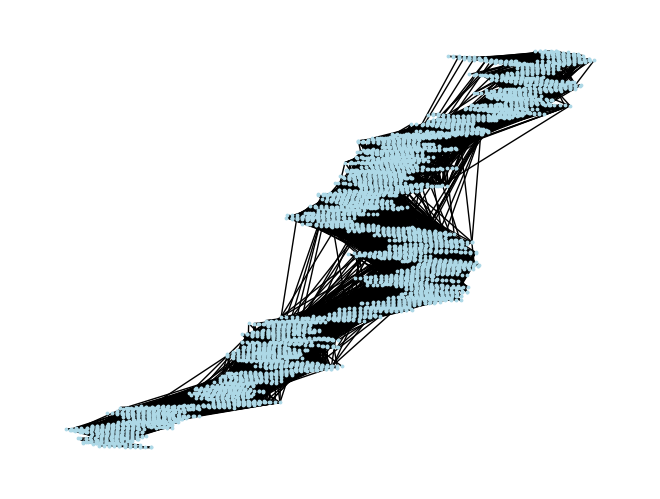

In [ ]:
import matplotlib.pyplot as plt
nx.draw(G_filtered, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=3)

plt.show()

In [7]:
# remove node overlaps
pos = nx.kamada_kawai_layout(G_filtered)
for node, (x, y) in pos.items():
    G_filtered.nodes[node]['x'] = x
    G_filtered.nodes[node]['y'] = y
nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions_kamada-kawai.graphml'))

KeyboardInterrupt: 